In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import cartopy.crs as ccrs
from PIL import Image
import dask
import datetime
import pandas as pd
import timeit
from itertools import product

In [2]:
M = 0.8 #change later
reference_fuel_consumption = 0.7296 #who knows
reference_nox = 19.1835 #IDGAF
number_of_engines = 2 
temp_sea_level = 288.15 #kelvins
pres_sea_level = 101325 #pascals
gamma = 1.4
R = 287.05

In [3]:
#merge echam, accf and contrail datasets for each month into datasets representing whole year
directory = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal")
directory_1percent = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_1pc")
directory_soc = os.fsencode("C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_optimal")
dir = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/AT20_optimal"
dir_1percent = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_1pc"
dir_soc = "C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/DT00/SOC_optimal"
echam_files = []
accf_files = []
contrail_files = []
airtraf_files = []
airtraf_ac_co_files = []
airtraf_ac_1percent_files = []
airtraf_ac_soc_files = []
airtraf_gp_soc_files = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith("ECHAM5.nc"):
        echam_files.append(os.path.join(dir, filename))
    elif filename.endswith("accf_gp.nc"):
        accf_files.append(os.path.join(dir, filename))
    elif filename.endswith("contrail_gp.nc"):
        contrail_files.append(os.path.join(dir, filename))
    elif filename.endswith("airtraf_gp.nc"):
        airtraf_files.append(os.path.join(dir, filename))
    elif filename.endswith("airtraf_ac.nc"):
        airtraf_ac_co_files.append(os.path.join(dir, filename))
    else:
        continue
for file in os.listdir(directory_1percent):
    filename = os.fsdecode(file)
    if filename.endswith("airtraf_ac.nc"):
        airtraf_ac_1percent_files.append(os.path.join(dir_1percent, filename))
    else:
        continue
for file in os.listdir(directory_soc):
    filename = os.fsdecode(file)
    if filename.endswith("airtraf_ac.nc"):
        airtraf_ac_soc_files.append(os.path.join(dir_soc, filename))
    elif filename.endswith("airtraf_gp.nc"):
        airtraf_gp_soc_files.append(os.path.join(dir_soc, filename))
    else:
        continue
if echam_files:
    merged_echam = xr.open_mfdataset(echam_files, combine='nested', concat_dim='time')
if accf_files:
    merged_accf = xr.open_mfdataset(accf_files, combine='nested', concat_dim='time')
if contrail_files:
    merged_contrail = xr.open_mfdataset(contrail_files, combine='nested', concat_dim='time')
if airtraf_files:
    merged_airtraf = xr.open_mfdataset(airtraf_files, combine='nested', concat_dim='time')
if airtraf_ac_co_files:
    merged_airtraf_ac_co = xr.open_mfdataset(airtraf_ac_co_files, combine='nested', concat_dim='time')
if airtraf_ac_1percent_files:
    merged_airtraf_ac_1percent = xr.open_mfdataset(airtraf_ac_1percent_files, combine='nested', concat_dim='time')
if airtraf_ac_soc_files:
    merged_airtraf_ac_soc = xr.open_mfdataset(airtraf_ac_soc_files, combine='nested', concat_dim='time')
if airtraf_gp_soc_files:
    merged_airtraf_gp_soc = xr.open_mfdataset(airtraf_gp_soc_files, combine='nested', concat_dim='time')

#taking 2018 as the only time period
merged_echam = merged_echam.sel(time = slice("2018-01-01", "2018-12-31"))
merged_accf = merged_accf.sel(time = slice("2018-01-01", "2018-12-31"))
merged_contrail = merged_contrail.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf = merged_airtraf.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_ac_co = merged_airtraf_ac_co.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_ac_1percent = merged_airtraf_ac_1percent.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_ac_soc = merged_airtraf_ac_soc.sel(time = slice("2018-01-01", "2018-12-31"))
merged_airtraf_gp_soc = merged_airtraf_gp_soc.sel(time = slice("2018-01-01", "2018-12-31"))

In [4]:
#aircrafts velocity based on its mach number
velocity_uncompressed = M*np.sqrt(gamma*R*merged_echam['tm1']) #m/s
#correction coefficients for fuel consumption
delta_uncompressed = merged_echam['tm1']*(1+0.2*M**2)**3.5 / temp_sea_level
theta_uncompressed = merged_echam['press']*(1+0.2*M**2)**3.5 / pres_sea_level
#actual fuel consumption per engine
f_a_i_uncompressed = reference_fuel_consumption*delta_uncompressed*np.sqrt(theta_uncompressed) #kg/s
#total fuel consumption
f_cr_uncompressed = f_a_i_uncompressed*number_of_engines #kg/s
#humidity correction coefficient
H_c_uncompressed = np.exp(-19*(merged_echam['qm1']-0.00634))
#nox emission corrected for cruise conditions
EINO_x_uncompressed = reference_nox*delta_uncompressed**0.4*theta_uncompressed**0.3*H_c_uncompressed #g/kg
#F-ATR20 for each emission in kelvins per kilometer
co2_atr20_perkm_uncompressed = merged_accf['atr20_co2']/velocity_uncompressed*f_cr_uncompressed*1000 #K/km
h2o_atr20_perkm_uncompressed = merged_accf['atr20_h2o']/velocity_uncompressed*f_cr_uncompressed*1000 #K/km
o3_atr20_perkm_uncompressed = merged_accf['atr20_o3']/velocity_uncompressed*f_cr_uncompressed*EINO_x_uncompressed*10**(-3)*1000 #K/km
ch4_atr20_perkm_uncompressed = merged_accf['atr20_ch4']/velocity_uncompressed*f_cr_uncompressed*EINO_x_uncompressed*10**(-3)*1000 #K/km
contr_atr20_perkm_uncompressed = merged_accf['atr20_contrail']*merged_contrail['potcov'] #?
total_atr20_perkm_uncompressed = co2_atr20_perkm_uncompressed + h2o_atr20_perkm_uncompressed + o3_atr20_perkm_uncompressed + ch4_atr20_perkm_uncompressed + contr_atr20_perkm_uncompressed

In [5]:
columns = ['month', 'day', 'time', 'i_cost', 'i_1p', 'i_climate', 'abs_comp', 'abs_opt', 'rel_comp', 'rel_opt']
gerben = pd.read_csv('gerben_output/aa_high_potential_list_sorted_rel_climate.txt', header=None, names=columns)
# gerben_midnight = gerben[gerben['time'] == 0]
# gerben_midnight_500 = gerben_midnight.sort_values(by='rel_opt').head(500)
date_list = []
for i in range(len(gerben)):
    date_list.append(date(2018, gerben['month'].values[i], 1 + gerben['day'].values[i]))
index_list_cost = gerben['i_cost'].values
index_list_climate = gerben['i_climate'].values
cmb_arr = np.column_stack((date_list, index_list_climate))

# gerben_midnight_1day = gerben_midnight[gerben_midnight['month'] == 7][gerben_midnight['day'] == 24 ].sort_values(by='rel_opt')
# lst_1 = gerben_midnight_1day.iloc[:25]['i_cost'].values.tolist()
# lst_2 = gerben_midnight_1day.iloc[25:50]['i_cost'].values.tolist()
# lst_3 = gerben_midnight_1day.iloc[50:-25]['i_cost'].values.tolist()
# lst_4 = gerben_midnight_1day.iloc[-25:]['i_cost'].values.tolist()


NameError: name 'date' is not defined

In [6]:
mapped = total_atr20_perkm_uncompressed.interp(lev=[7, 9.141, 10.336, 11.270, 12.069, 12.759, 13.394, 14])
mapped

<xarray.DataArray (time: 365, lev: 8, lat: 64, lon: 128)>
dask.array<transpose, shape=(365, 8, 64, 128), dtype=float64, chunksize=(31, 8, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float32 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * lev      (lev) float64 7.0 9.141 10.34 11.27 12.07 12.76 13.39 14.0

Text(0.5, 1.0, 'ATR20 variance: 2018-07-25')

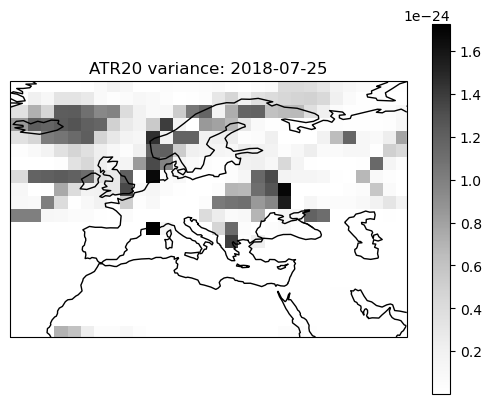

In [9]:
time_t = '2018-07-25'
#var = total_atr20_perkm_uncompressed.sel(lev=slice(10,12)).var(dim='lev')
var = mapped.var(dim='lev')
var = xr.concat([var.sel(lon=slice(0,67.5)), var.sel(lon=slice(337.5, 357.1875))], dim="lon")
varcopy = var
var = var.sel(time=time_t).sel(lat=slice(87.8638,18.138971))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
extent = [-25, 60, 20, 70]
ax.set_extent(extent)

# for i in lst_1:

#     lon = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=0).data
#     lat = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=1).data

#     plt.plot(lon, lat, transform=ccrs.PlateCarree(), color = 'lime', alpha=0.2)

# for i in lst_2:

#     lon = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=0).data
#     lat = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=1).data

#     plt.plot(lon, lat, transform=ccrs.PlateCarree(), color = 'blue', alpha=0.2)

# for i in lst_3:

#     lon = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=0).data
#     lat = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=1).data

#     plt.plot(lon, lat, transform=ccrs.PlateCarree(), color = 'orange', alpha=0.2)


# for i in lst_4:

#     lon = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=0).data
#     lat = merged_airtraf_ac_soc['routes_out'].sel(time=time_t).isel(AirTraf_routes_out=i, AirTraf_properties=1).data

#     plt.plot(lon, lat, transform=ccrs.PlateCarree(), color = 'r', alpha=0.2)

p = var.plot(transform=ccrs.PlateCarree(), cmap = 'Greys')#,vmin=6.9e-15, vmax=7.2e-15)
plt.title(label='ATR20 variance: ' + time_t)

In [7]:
columns_atr = ['Date', 'time', 'Flight index', 'ATRsum']
date = merged_airtraf_ac_soc.coords['time'].values
routes = np.arange(100)
lp1, lp2 = pd.core.reshape.util.cartesian_product([date, routes])
ATR_array = pd.DataFrame(dict(Date=lp1, time=0, Flight_index=lp2, ATRsum = 0))
ATR_array

,Date,time,Flight_index,ATRsum
0,2018-01-01,0,0,0
1,2018-01-01,0,1,0
2,2018-01-01,0,2,0
3,2018-01-01,0,3,0
4,2018-01-01,0,4,0
...,...,...,...,...
36495,2018-12-31,0,95,0
36496,2018-12-31,0,96,0
36497,2018-12-31,0,97,0
36498,2018-12-31,0,98,0


In [61]:
columns_atr = ['Date', 'time', 'Flight index', 'ATRsum']
date = merged_airtraf_ac_soc.coords['time'].values
routes = np.arange(100)
lp1, lp2 = pd.core.reshape.util.cartesian_product([date, routes])
ATR_array = pd.DataFrame(dict(Date=lp1, time=0, Flight_index=lp2, ATRsum=float(0)))
ATR_array['Date'] = pd.to_datetime(ATR_array["Date"])
ATR_array
# ATR_array['Date'].values
# ATR_array['Date'].dt.month == 1

,Date,time,Flight_index,ATRsum
0,2018-01-01,0,0,0.0
1,2018-01-01,0,1,0.0
2,2018-01-01,0,2,0.0
3,2018-01-01,0,3,0.0
4,2018-01-01,0,4,0.0
...,...,...,...,...
36495,2018-12-31,0,95,0.0
36496,2018-12-31,0,96,0.0
36497,2018-12-31,0,97,0.0
36498,2018-12-31,0,98,0.0


In [72]:
lon_prop = merged_airtraf_ac_soc['routes_out'].isel(AirTraf_properties=0)
lat_prop = merged_airtraf_ac_soc['routes_out'].isel(AirTraf_properties=1)

for index, row in ATR_array.iterrows():
    if row['Date'].month == 1 and row['Date'].day == 1:
        t = row["Date"]
        fid = row["Flight_index"]
        lon_fin = lon_prop.sel(time=t).isel(AirTraf_routes_out=fid) 
        lat_fin = lat_prop.sel(time=t).isel(AirTraf_routes_out=fid)
        x = lon_fin.values
        y = lat_fin.values
        summed_values = float(0)
        # print(route," 2")
        print(t, fid, " 2")
        for w in range(101):
            x_t = x[w]
            y_t = y[w]

            if x_t < (357.1875-360)/2:
                x_t += 360
            print(1)
            valvar = varcopy.sel(time = t, lon = x_t, lat = y_t, method='nearest').values
            print(summed_values)
            summed_values += valvar
            print(3)
        
        # print(t, fid, " 3")

        row['ATRsum']  = summed_values
    
        # print(t, fid, " 4")
# ATR_array.to_csv(path_or_buf="C:/Users/macie/OneDrive/Desktop/Project_A02/Project_data/ATR_arrays/ATR_array_1.csv", float_format=)
ATR_array

2018-01-01 00:00:00 0  2
1
0.0
3
1
6.337183820861204e-25
3
1
1.2674367641722407e-24
3
1
1.901155146258361e-24
3
1
2.5348735283444815e-24
3
1
3.168591910430602e-24
3
1
3.8023102925167226e-24
3
1
4.436028674602843e-24
3
1
5.069747056688964e-24
3
1
5.703465438775084e-24
3
1
6.337183820861205e-24
3
1
6.970902202947325e-24
3
1
7.604620585033445e-24
3
1
8.238338967119565e-24
3
1
8.872057349205685e-24
3
1
9.505775731291805e-24
3
1
1.0139494113377924e-23
3
1


KeyboardInterrupt: 

In [85]:
varcopy.sel(time = t, lon = x_t, lat = y_t, method='nearest')

<xarray.DataArray ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2018-01-01
    lon      float32 11.25
    lat      float32 40.46

In [ ]:
lon_prop = merged_airtraf_ac_soc['routes_out'].isel(AirTraf_properties=0)
lat_prop = merged_airtraf_ac_soc['routes_out'].isel(AirTraf_properties=1)

for index, row in ATR_array.iterrows():
    t = row["Date"]
    fid = row["Flight_index"]
    lon_fin = lon_prop.sel(time=t).isel(AirTraf_routes_out=fid) 
    lat_fin = lat_prop.sel(time=t).isel(AirTraf_routes_out=fid)
    x = lon_fin.values
    y = lat_fin.values
    summed_values = float(0)
    # print(route," 2")
    print(t, fid, " 2")
    for w in range(101):
        x_t = x[w]
        y_t = y[w]

        if x_t < (357.1875-360)/2:
            x_t += 360

        valvar = varcopy.sel(time = t, lon = x_t, lat = y_t, method='nearest')
        summed_values += valvar
    print(t, fid, " 3")
    row['ATRsum']  = summed_values
    print(t, fid, " 4")

In [ ]:

columns_atr = ['Date', 'time', 'Flight index', 'ATRsum']
lst = []
date = merged_airtraf_ac_soc.coords['time']
time = 0
routes = np.arange(100)
ATR_array = pd.DataFrame(columns=columns_atr)
# ATR_array = np.zeros((4, 4))
lon_prop = merged_airtraf_ac_soc['routes_out'].isel(AirTraf_properties=0)
lat_prop = merged_airtraf_ac_soc['routes_out'].isel(AirTraf_properties=1)
for t in date:
    print(t)
    lon_t = lon_prop.sel(time=t)
    lat_t = lat_prop.sel(time=t)
    for route in range(2):
        print(route)
        lon_fin = lon_t.isel(AirTraf_routes_out=route)        
        lat_fin = lat_t.isel(AirTraf_routes_out=route)

        x = lon_fin.values
        y = lat_fin.values
        summed_values = float(0)
        print(route," 2")
        for w in range(101):
            x_t = x[w]
            y_t = y[w]

            if x_t < (357.1875-360)/2:
                x_t += 360

            valvar = varcopy.sel(time = t, lon = x_t, lat = y_t, method='nearest')
            summed_values += valvar
        print(route, " 3")
        ATR_array.loc[len(ATR_array.index)] = [summed_values]
        # np.append(ATR_array, [[t, 0, route, summed_values]], axis=0)
ATR_array

In [ ]:
for i in merged_airtraf_ac_soc.dims["AirTraf_routes_out"]:
    print(i)